#1 XGBoost计算样本错误率

In [2]:
import xgboost as xgb
import numpy as np

# 定义f: theta * x
def log_reg(y_hat, y):
    p = 1.0 / (1.0 + np.exp(-y_hat))
    g = p - y.get_label()
    h = p * (1.0-p)
    return g, h

def error_rate(y_hat, y):
    return 'error', float(sum(y.get_label() != (y_hat > 0.5))) / len(y_hat)

# 读取数据
data_train = xgb.DMatrix('data/agaricus_train.txt')
data_test = xgb.DMatrix('data/agaricus_test.txt')
print(data_train)
print(type(data_train))

# 设置参数
param = {'max_depth': 3, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'} # logitraw
# param = {'max_depth': 3, 'eta': 0.3, 'silent': 1, 'objective': 'reg:logistic'}
watchlist = [(data_test, 'eval'), (data_train, 'train')]
n_round = 7
# bst = xgb.train(param, data_train, num_boost_round=n_round, evals=watchlist)
bst = xgb.train(param, data_train, num_boost_round=n_round, evals=watchlist, obj=log_reg, feval=error_rate)

# 计算错误率
y_hat = bst.predict(data_test)
y = data_test.get_label()
print(y_hat)
print(y)
error = sum(y != (y_hat > 0.5))
error_rate = float(error) / len(y_hat)
print('样本总数：\t', len(y_hat))
print('错误数目：\t%4d' % error)
print('错误率：\t%.5f%%' % (100*error_rate))

<class 'xgboost.core.DMatrix'>
[0]	eval-error:0.016139	train-error:0.014433	eval-error:0.016139	train-error:0.014433


[1]	eval-error:0.016139	train-error:0.014433	eval-error:0.016139	train-error:0.014433


[2]	eval-error:0.016139	train-error:0.014433	eval-error:0.016139	train-error:0.014433


[3]	eval-error:0.016139	train-error:0.014433	eval-error:0.016139	train-error:0.014433


[4]	eval-error:0.002483	train-error:0.003071	eval-error:0.002483	train-error:0.003071


[5]	eval-error:0.002483	train-error:0.003071	eval-error:0.002483	train-error:0.003071


[6]	eval-error:0.002483	train-error:0.003071	eval-error:0.002483	train-error:0.003071


[  6.09937888e-06   9.84727502e-01   6.09937888e-06 ...,   9.99932647e-01
   4.45600620e-07   9.99932647e-01]
[ 0.  1.  0. ...,  1.  0.  1.]
样本总数：	 1611
错误数目：	   4
错误率：	0.24829%


#2 Logisitic回归与XGBoost的比较-Wine实例

In [3]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split   # cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 作业：尝试用Pandas读取试试？
data = np.loadtxt('data/wine.data', dtype=float, delimiter=',')
y, x = np.split(data, (1,), axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.5)

# Logistic回归
lr = LogisticRegression(penalty='l2')
lr.fit(x_train, y_train.ravel())
y_hat = lr.predict(x_test)
print('Logistic回归正确率：', accuracy_score(y_test, y_hat))

# XGBoost
y_train[y_train == 3] = 0
y_test[y_test == 3] = 0
data_train = xgb.DMatrix(x_train, label=y_train)
data_test = xgb.DMatrix(x_test, label=y_test)
watch_list = [(data_test, 'eval'), (data_train, 'train')]
params = {'max_depth': 3, 'eta': 1, 'silent': 0, 'objective': 'multi:softmax', 'num_class': 3}
bst = xgb.train(params, data_train, num_boost_round=2, evals=watch_list)
y_hat = bst.predict(data_test)
print('XGBoost正确率：', accuracy_score(y_test, y_hat))

Logistic回归正确率： 0.943820224719
[0]	eval-merror:0.011236	train-merror:0


[1]	eval-merror:0	train-merror:0


XGBoost正确率： 1.0


#3 Logisitic回归与XGBoost的比较-agaricus

In [4]:
import xgboost as xgb
import numpy as np
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def read_data(path):
    y = []
    row = []
    col = []
    values = []
    r = 0       # 首行
    for d in open(path):
        d = d.strip().split()      # 以空格分开
        y.append(int(d[0]))
        d = d[1:]
        for c in d:
            key, value = c.split(':')
            row.append(r)
            col.append(int(key))
            values.append(float(value))
        r += 1
    x = scipy.sparse.csr_matrix((values, (row, col))).toarray()
    y = np.array(y)
    return x, y

x, y = read_data('data/agaricus_train.txt')
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, train_size=0.6)

# Logistic回归
lr = LogisticRegression(penalty='l2')
lr.fit(x_train, y_train.ravel())
y_hat = lr.predict(x_test)
print('Logistic回归正确率：', accuracy_score(y_test, y_hat))

# XGBoost
data_train = xgb.DMatrix(x_train, label=y_train)
data_test = xgb.DMatrix(x_test, label=y_test)
watch_list = [(data_test, 'eval'), (data_train, 'train')]
param = {'max_depth': 3, 'eta': 1, 'silent': 0, 'objective': 'multi:softmax', 'num_class': 3}
bst = xgb.train(param, data_train, num_boost_round=4, evals=watch_list)
y_hat = bst.predict(data_test)
print('XGBoost正确率：', accuracy_score(y_test, y_hat))

Logistic回归正确率： 1.0
[0]	eval-merror:0.035687	train-merror:0.040696


[1]	eval-merror:0.007291	train-merror:0.009982


[2]	eval-merror:0.000767	train-merror:0.000512


[3]	eval-merror:0.000767	train-merror:0.000512


XGBoost正确率： 0.999232540292


#4 使用XGBoost对鸢尾花数据计算正确率

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split   # cross_validation

def iris_type(s):
    it = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    return it[s]

data = pd.read_csv('data/iris.data', header=None)
x = data.values[:,:4]
y_prime = data.values[:, -1:]

YY = []
for index, vec in enumerate(y_prime):
    YY.append(vec[0])

y = pd.Categorical(YY).codes
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=50)

data_train = xgb.DMatrix(x_train, label=y_train)
data_test = xgb.DMatrix(x_test, label=y_test)
watch_list = [(data_test, 'eval'), (data_train, 'train')]
param = {'max_depth': 2, 'eta': 0.3, 'silent': 1, 'objective': 'multi:softmax', 'num_class': 3}

bst = xgb.train(param, data_train, num_boost_round=6, evals=watch_list)
y_hat = bst.predict(data_test)
result = y_test.reshape(1, -1) == y_hat
print('正确率:\t', float(np.sum(result)) / len(y_hat))
print('END.....\n')

[0]	eval-merror:0.04	train-merror:0.04


[1]	eval-merror:0.04	train-merror:0.04


[2]	eval-merror:0.02	train-merror:0.02


[3]	eval-merror:0.02	train-merror:0.02


[4]	eval-merror:0.02	train-merror:0.02


[5]	eval-merror:0.02	train-merror:0.02


正确率:	 0.98
END.....



#5 Logistic回归、随机森林和XGBoost的比较

In [18]:
import xgboost as xgb
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import csv

def show_accuracy(a, b, tip):
    acc = a.ravel() == b.ravel()
    acc_rate = 100 * float(acc.sum()) / a.size
    print('%s正确率：%.3f%%' % (tip, acc_rate))
    return acc_rate


def load_data(file_name, is_train):
    data = pd.read_csv(file_name)  # 数据文件路径

    # 性别
    data['Sex'] = data['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # 补齐船票价格缺失值
    if len(data.Fare[data.Fare.isnull()]) > 0:
        fare = np.zeros(3)
        for f in range(0, 3):
            fare[f] = data[data.Pclass == f + 1]['Fare'].dropna().median()
        for f in range(0, 3):  # loop 0 to 2
            data.loc[(data.Fare.isnull()) & (data.Pclass == f + 1), 'Fare'] = fare[f]

    # 年龄：使用均值代替缺失值
    if is_train:
        # 年龄：使用随机森林预测年龄缺失值
        data_for_age = data[['Age', 'Survived', 'Fare', 'Parch', 'SibSp', 'Pclass']]
        age_exist = data_for_age.loc[(data.Age.notnull())]   # 年龄不缺失的数据
        age_null = data_for_age.loc[(data.Age.isnull())]
        # print age_exist
        x = age_exist.values[:, 1:]
        y = age_exist.values[:, 0]
        rfr = RandomForestRegressor(n_estimators=1000)
        rfr.fit(x, y)
        age_hat = rfr.predict(age_null.values[:, 1:])
        # print age_hat
        data.loc[(data.Age.isnull()), 'Age'] = age_hat
    else:
        data_for_age = data[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
        age_exist = data_for_age.loc[(data.Age.notnull())]  # 年龄不缺失的数据
        age_null = data_for_age.loc[(data.Age.isnull())]
        x = age_exist.values[:, 1:]
        y = age_exist.values[:, 0]
        rfr = RandomForestRegressor(n_estimators=1000)
        rfr.fit(x, y)
        age_hat = rfr.predict(age_null.values[:, 1:])
        data.loc[(data.Age.isnull()), 'Age'] = age_hat

    # 起始城市
    data.loc[(data.Embarked.isnull()), 'Embarked'] = 'S'  # 保留缺失出发城市
    embarked_data = pd.get_dummies(data.Embarked)
    embarked_data = embarked_data.rename(columns=lambda x: 'Embarked_' + str(x))
    data = pd.concat([data, embarked_data], axis=1)
    data.to_csv('New_Data.csv')

    x = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
    y = None
    if 'Survived' in data:
        y = data['Survived']

    x = np.array(x)
    y = np.array(y)

    # 思考：这样做，其实发生了什么？
    x = np.tile(x, (5, 1))
    y = np.tile(y, (5, ))
    if is_train:
        return x, y
    return x, data['PassengerId']


def write_result(c, c_type):
    file_name = 'data/Titanic.test.csv'
    x, passenger_id = load_data(file_name, False)

    if type == 3:
        x = xgb.DMatrix(x)
    y = c.predict(x)
    y[y > 0.5] = 1
    y[~(y > 0.5)] = 0

    predictions_file = open("Prediction_%d.csv" % c_type, "wb")
    open_file_object = csv.writer(predictions_file)
    open_file_object.writerow(["PassengerId", "Survived"])
    open_file_object.writerows(zip(passenger_id, y))
    predictions_file.close()


x, y = load_data('data/Titanic.train.csv', True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

lr = LogisticRegression(penalty='l2')
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)
lr_acc = accuracy_score(y_test, y_hat)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)
y_hat = rfc.predict(x_test)
rfc_acc = accuracy_score(y_test, y_hat)

# XGBoost
data_train = xgb.DMatrix(x_train, label=y_train)
data_test = xgb.DMatrix(x_test, label=y_test)
watch_list = [] #[(data_test, 'eval'), (data_train, 'train')]
param = {'max_depth': 6, 'eta': 0.8, 'silent': 1, 'objective': 'binary:logistic'}
bst = xgb.train(param, data_train, num_boost_round=100, evals=watch_list)
y_hat = bst.predict(data_test)
y_hat[y_hat > 0.5] = 1
y_hat[~(y_hat > 0.5)] = 0
xgb_acc = accuracy_score(y_test, y_hat)

print('Logistic回归：%.3f%%' % lr_acc)
print('随机森林：%.3f%%' % rfc_acc)
print('XGBoost：%.3f%%' % xgb_acc)

Logistic回归：0.805%
随机森林：0.983%
XGBoost：0.983%


#6 使用XGBoost对鸢尾花数据进行分类

[0]	eval-merror:0.2	train-merror:0.175


[1]	eval-merror:0.2	train-merror:0.166667


[2]	eval-merror:0.2	train-merror:0.175


[3]	eval-merror:0.2	train-merror:0.175


XGBoost正确率： 0.8


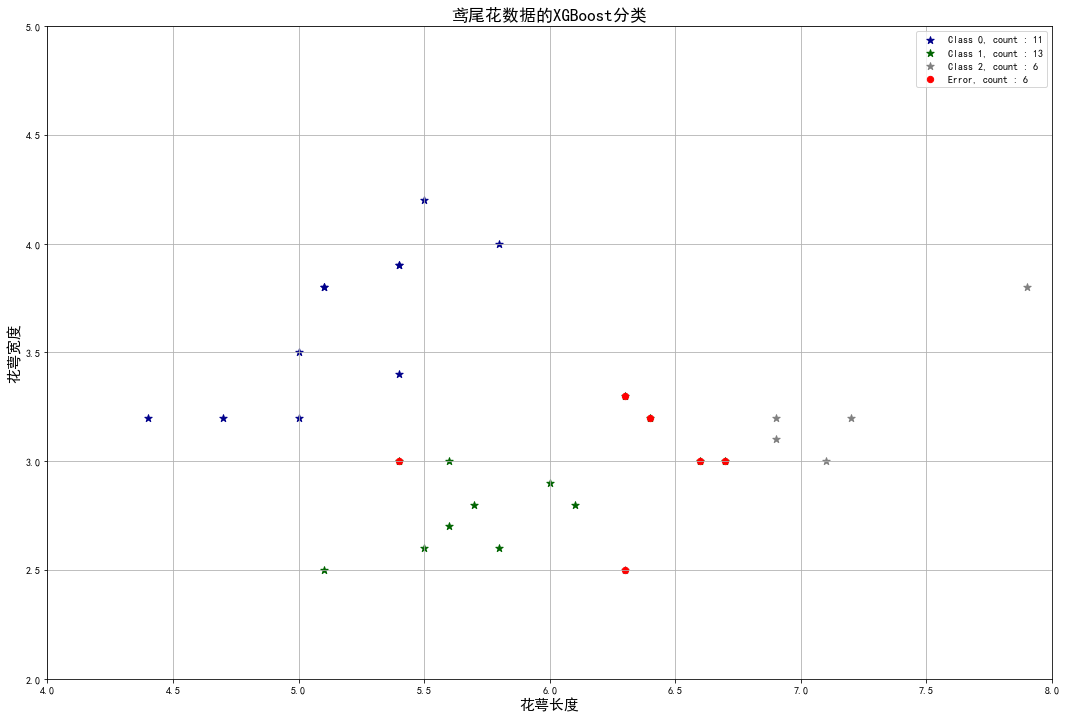

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 花萼长度、花萼宽度，花瓣长度，花瓣宽度
iris_feature_E = 'sepal length', 'sepal width', 'petal length', 'petal width'
iris_feature = u'花萼长度', u'花萼宽度', u'花瓣长度', u'花瓣宽度'
iris_class = 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'

mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

data = pd.read_csv('data/iris.data', header=None)
x = data[np.arange(4)]
y = pd.Categorical(data[4]).codes

x = x.iloc[:, :2]# 为了可视化，仅使用前两列特征
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)

x1_min, x2_min = x.min()
x1_max, x2_max = x.max()

# 决策树参数估计
data_train = xgb.DMatrix(x_train, label=y_train)
data_test = xgb.DMatrix(x_test, label=y_test)
watch_list = [(data_test, 'eval'), (data_train, 'train')]
param = {
    'booster':'gbtree', # gbtree || gblinear
    'max_depth': 3, # 树的深度越大，则对数据的拟合程度越高
    'eta': 0.2, #为了防止过拟合，更新过程中用到的收缩步长
    'silent': 1, # 0 print details 1 print nothing
    'objective': 'multi:softmax', 
    'num_class': 3}
bst = xgb.train(param, data_train, num_boost_round=4, evals=watch_list)
y_hat = bst.predict(data_test)
print('XGBoost正确率：', accuracy_score(y_test, y_hat))

plt.figure(figsize=(18, 12), facecolor='w')
incorrect_idx = np.where(y_hat != y_test)[0]
colors = ["darkblue","darkgreen","gray"]
x_test = np.array(x_test)
for n, color in enumerate(colors):
    idx = np.where(y_test == n)[0]
    plt.scatter(x_test[idx,0],x_test[idx,1],c=color,s = 60, marker='*', label="Class %s, count : %d" % (n,len(idx)))

plt.scatter(x_test[incorrect_idx, 0],x_test[incorrect_idx,1], c = 'r',s = 40, marker='o',label="Error, count : %d" % len(incorrect_idx))
plt.xlabel(iris_feature[0], fontsize=15)
plt.ylabel(iris_feature[1], fontsize=15)

plt.xlim(4, 8)
plt.ylim(2, 5)
plt.legend(loc="upper right")
plt.grid(True)
plt.title(u'鸢尾花数据的XGBoost分类', fontsize=17)
plt.show()